In [ ]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers # type: ignore
from tensorflow.keras import models, layers # type: ignore
from tensorflow.keras.applications import MobileNetV2 # type: ignore
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage import io
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

Number of classes in dataset folder: 2
Total samples: 2000
Number of samples in train: 1600
Number of samples in test: 400


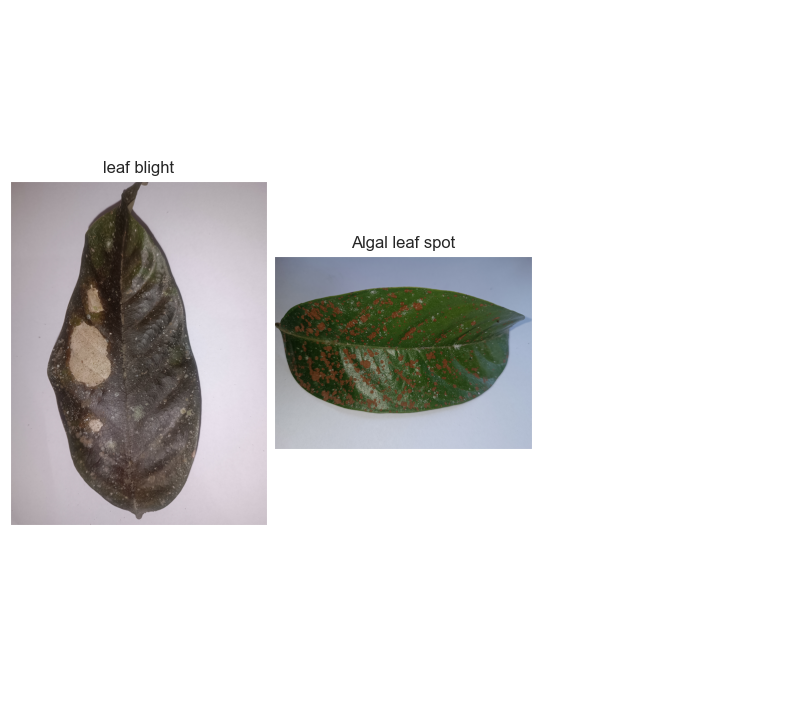

In [ ]:

# 1. Import Data 
base_dir = 'dataset' 

# 1.1 Count data and classes has 
def num_of_classes(folder_dir, folder_name):
    classes = [class_name for class_name in os.listdir(folder_dir)]
    print(colored(f'Number of classes in {folder_name} folder: {len(classes)}', 'blue', attrs=['bold']))
    return classes

classes = num_of_classes(base_dir, 'dataset')

# 1.2 Create DataFrame with file paths and labels
def create_df(folder_path):
    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

df = create_df(base_dir)
print(colored(f'Total samples: {len(df)}', 'blue', attrs=['bold']))

# 1.3 Split data manually
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

print(colored(f'Number of samples in train: {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in test: {len(test_df)}', 'blue', attrs=['bold']))

# 1.4 Show an image per class (optional)
# Show an image per each class(label)
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index(drop=True)


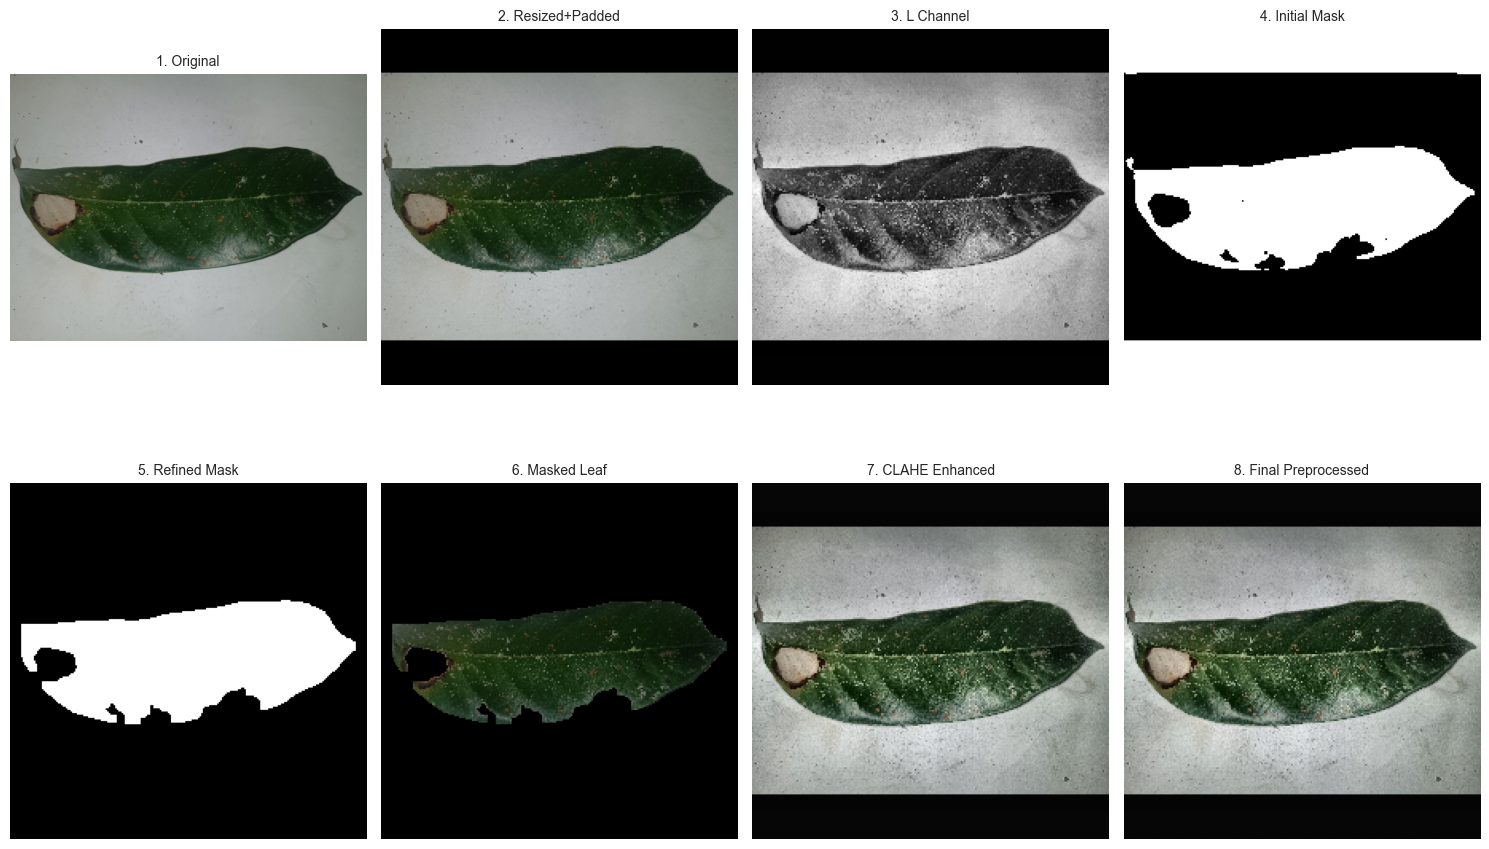

In [ ]:
# Visualization Helper Functions with Random Image Selection


def load_image(path):
    """Load and prepare image"""
    img = io.imread(path)
    if img is None:
        raise ValueError(f"Couldn't load image from {path}")
    
    # Convert RGBA to RGB or Grayscale to RGB
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    elif len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return img

def get_random_image_from_dataset(dataset_path):
    """Get a random image path from the dataset directory"""
    # Get all image files from the directory and subdirectories
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    image_paths = []
    
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if any(file.lower().endswith(ext) for ext in image_extensions):
                image_paths.append(os.path.join(root, file))
    
    if not image_paths:
        raise FileNotFoundError(f"No images found in {dataset_path}")
    
    return random.choice(image_paths)

def plot_processing_steps(image_path, figsize=(15, 10)):
    """Visualize all preprocessing steps in a grid layout"""
    # 1. Load original
    original = load_image(image_path)
    
    # 2. Resize with aspect ratio preservation
    target_size = (224, 224)
    h, w = original.shape[:2]
    scale = min(target_size[0]/h, target_size[1]/w)
    new_size = (int(w*scale), int(h*scale))
    resized = cv2.resize(original, new_size)
    
    # Add padding
    pad_x = max(0, (target_size[1] - new_size[0]) // 2)
    pad_y = max(0, (target_size[0] - new_size[1]) // 2)
    padded = cv2.copyMakeBorder(resized, 
                              pad_y, pad_y,
                              pad_x, pad_x,
                              cv2.BORDER_CONSTANT, 
                              value=[0,0,0])

    # 3. Convert to LAB color space
    lab = cv2.cvtColor(padded, cv2.COLOR_RGB2LAB)
    l_channel = lab[:,:,0]

    # 4. Create leaf mask (Otsu's thresholding)
    blurred = cv2.GaussianBlur(l_channel, (5,5), 0)
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 5. Refine mask
    kernel = np.ones((3,3), np.uint8)
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Keep only largest contour
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(cleaned)
    if contours:
        largest = max(contours, key=cv2.contourArea)
        cv2.drawContours(final_mask, [largest], -1, 255, thickness=cv2.FILLED)

    # 6. Apply mask
    masked = cv2.bitwise_and(padded, padded, mask=final_mask)

    # 7. Enhance contrast (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    lab[:,:,0] = clahe.apply(lab[:,:,0])
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    # 8. Final normalized image
    final = enhanced.astype(np.float32) / 255.0

    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot all steps
    steps = [
        ("1. Original", original, None),
        ("2. Resized+Padded", padded, None),
        ("3. L Channel", l_channel, 'gray'),
        ("4. Initial Mask", mask, 'gray'),
        ("5. Refined Mask", final_mask, 'gray'),
        ("6. Masked Leaf", masked, None),
        ("7. CLAHE Enhanced", enhanced, None),
        ("8. Final Preprocessed", final, None)
    ]
    
    for i, (title, image, cmap) in enumerate(steps, 1):
        plt.subplot(2, 4, i)
        plt.title(title, fontsize=10)
        if cmap:
            plt.imshow(image, cmap=cmap)
        else:
            plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage (commented out - uncomment when you want to visualize)
dataset_path = "dataset"  # Path to your dataset directory
random_image_path = get_random_image_from_dataset(dataset_path)
plot_processing_steps(random_image_path)

In [4]:
# 2. Data generators
# Train and Validation Generators
#
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    shear_range=0.1,
    fill_mode='nearest',
    validation_split=0.2  # Split for validation
)

# Train Generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='training',
    shuffle=True,
    seed=42,
)

# Validation Generator
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    subset='validation',
    seed=42,
    shuffle=False
)

# Test Generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)


Found 1280 validated image filenames belonging to 2 classes.
Found 320 validated image filenames belonging to 2 classes.
Found 400 validated image filenames belonging to 2 classes.


In [5]:

# 3. Model with MobileNetV2
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze all layers except the last block
pre_trained_model.trainable = True
set_trainable = False
for layer in pre_trained_model.layers:
    if layer.name == 'block_16_expand':
        set_trainable = True
    layer.trainable = set_trainable

# 4. Define the Model
model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2619074 (9.99 MB)
Trainable params: 1247170 (4.76 MB)
Non-trainable params: 1371904 (5.23 MB)
______________

In [6]:

# 5. Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Callbacks
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# 7. Train Model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=20,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/20
40/40 [==============================] - 174s 4s/step - loss: 0.2456 - accuracy: 0.8898 - val_loss: 10.0493 - val_accuracy: 0.5281 - lr: 0.0010
Epoch 2/20
40/40 [==============================] - 167s 4s/step - loss: 0.1036 - accuracy: 0.9625 - val_loss: 7.8364 - val_accuracy: 0.5406 - lr: 0.0010
Epoch 3/20
40/40 [==============================] - 165s 4s/step - loss: 0.0693 - accuracy: 0.9719 - val_loss: 4.7860 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 4/20
40/40 [==============================] - 156s 4s/step - loss: 0.0723 - accuracy: 0.9781 - val_loss: 3.7616 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 5/20
40/40 [==============================] - 103s 3s/step - loss: 0.0471 - accuracy: 0.9828 - val_loss: 6.2982 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 6/20
40/40 [==============================] - 103s 3s/step - loss: 0.0446 - accuracy: 0.9852 - val_loss: 3.6084 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 7/20
40/40 [==============================] - 103s 3s/step - loss: 0.

13/13 [==============================] - 24s 2s/step
                 precision    recall  f1-score   support

Algal leaf spot       0.97      1.00      0.99       200
    leaf blight       1.00      0.97      0.98       200

       accuracy                           0.98       400
      macro avg       0.99      0.98      0.98       400
   weighted avg       0.99      0.98      0.98       400



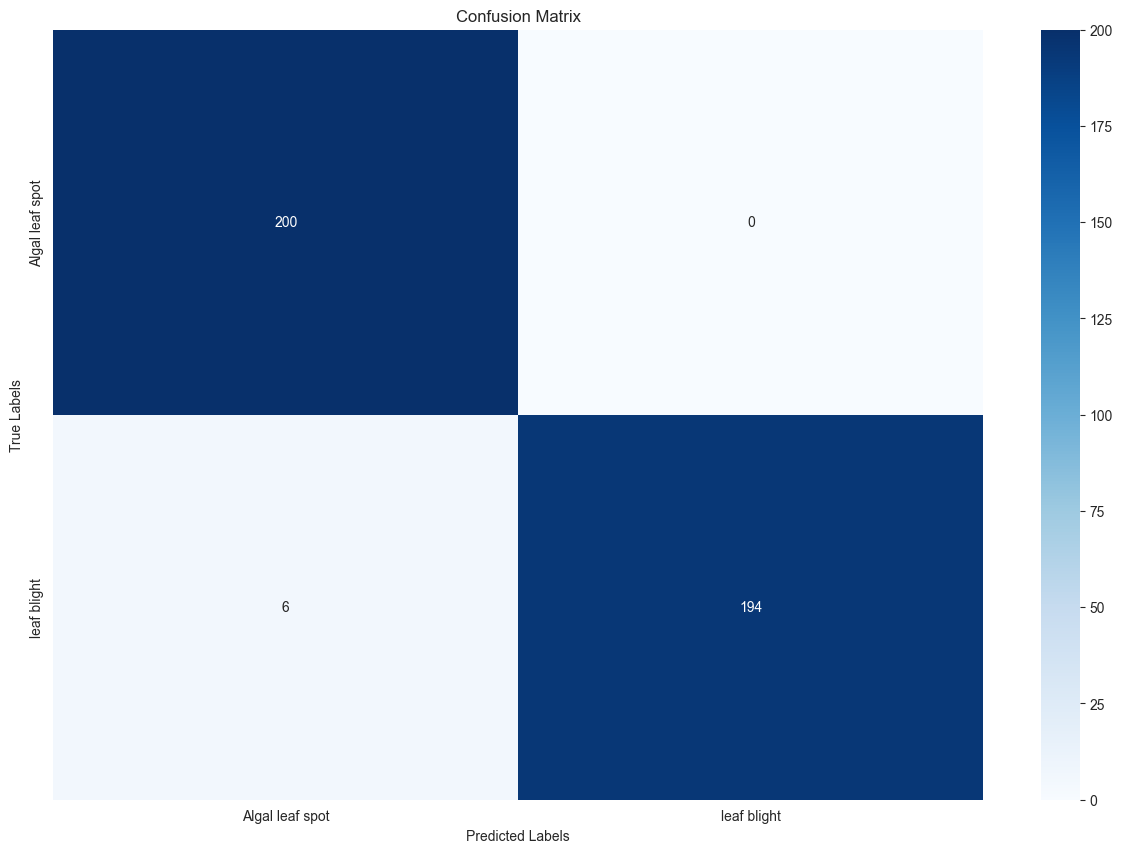

In [7]:
# 8. Save the trained model
model.save('lods.h5')

# 9. Evaluate Model Performance
best_model = models.load_model('lods.h5')

def evaluate_model_performance(model, test_generator, class_labels):
    """
    Evaluate the model's performance on the test set and print the classification report.

    Parameters:
    - model: The trained model.
    - test_generator: Test data generator.
    - class_labels: List of class names.
    """
    true_labels = test_generator.classes
    predictions = model.predict(test_generator, steps=len(test_generator))
    predicted_labels = np.argmax(predictions, axis=1)

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(15, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_model_performance(best_model, test_generator, classes)


13/13 [==============================] - 23s 2s/step - loss: 0.0781 - accuracy: 0.9850

Model Evaluation Results:
Training Accuracy: 0.9680
Testing Accuracy: 0.9850


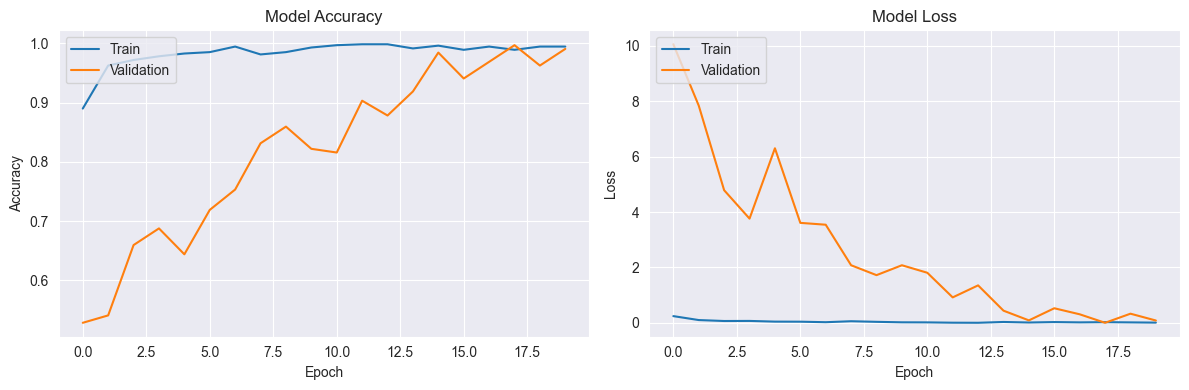

In [17]:
# After your model training code, add evaluation metrics
def print_model_accuracy(model, train_generator, test_generator):
    # Evaluate on training data
    train_results = model.evaluate(train_generator)
    train_accuracy = train_results[1]  # Assuming accuracy is the second metric
    
    # Evaluate on test data
    test_results = model.evaluate(test_generator)
    test_accuracy = test_results[1]
    
    print("\nModel Evaluation Results:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    
    return train_accuracy, test_accuracy

# Call this function after training
train_acc, test_acc = print_model_accuracy(model, train_generator, test_generator)




# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call this function after training
plot_training_history(history)

In [8]:


import tensorflow as tf
# Load the model
model = models.load_model('lods.h5')

# Convert Keras model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable custom ops if needed
converter.allow_custom_ops = True

# Apply optimization (optional)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Disable the new converter to avoid warnings
converter.experimental_new_converter = False

# Convert the model
tflite_model = converter.convert()

# Save the converted TensorFlow Lite model to a file
with open('lods.tflite', 'wb') as f:
    f.write(tflite_model)